# DSCI 511 – Term Project (Phase 2): Creating the Dataset

**Team Members:**  
- Roy Phelps  
- Shad Scarboro  
- Even Wessel  
- Leland Weeks  

This notebook **cleans and prepares** the Heart Attack China dataset and WHO dataset, producing three processed outputs:

- **Analysis-ready:** `../data/processed/heart_attack_china_analysis_ready.csv`  
- **Model-ready:** `../data/processed/heart_attack_china_model_ready.csv`  
- **Merged (with WHO context):** `../data/processed/heart_attack_china_with_who_latest_by_sex.csv`  

> **Note:** In this phase of the project we primarily use the **analysis-ready** file and the **WHO-merged** file for figures and discussion.  
> The **model-ready** file is included as a cleaned, feature-focused version of the data that can support **future predictive modeling** (e.g., logistic regression, tree-based models, or additional coursework). 

---

# Raw Inputs and Processing Steps

**Raw Input Paths**

- Heart attack data: `../data/raw/heart_attack_china.csv`  
- WHO data: `../data/raw/who_health_china.csv`  
- Air quality data via the OpenAQ API  
- OpenStreetMap (via Nominatim and GeoJSON)  
- Output directory: `../data/processed`  

**Processing Overview**

- Clean heart attack data and engineer key features (e.g., gender, SBP flags, yes/no mappings).  
- Clean WHO data, keep the *latest year* per indicator × sex, and pivot it to a wide format.  
- Map `Gender_simple` → WHO sex codes and join datasets.  
- Generate:
  - an **analysis-ready** dataset for descriptive statistics and figures,  
  - a **model-ready** dataset for potential future predictive modeling, and  
  - a **merged dataset** that links heart attack data to province-level WHO indicators.




## 1) Combining `heart_attack_china` and `who_health_china`

In this section we:

1. **Load** the raw heart attack data (`heart_attack_china.csv`) and the WHO indicators for China (`who_health_china.csv`).  
2. **Clean and standardize** key fields (e.g., province names, sex codes, and indicator names).  
3. **Aggregate and pivot** the WHO data so that, for each province × sex, we keep the **most recent year** available for each indicator.  
4. **Merge** the heart attack dataset with the processed WHO data using province and sex mappings.

The result of this step is a **wide, province-level dataset** that links individual heart attack records to contextual health indicators from WHO.



In [1]:

# Import and file paths
import pandas as pd
from pathlib import Path

RAW_PATH = "../data/raw/heart_attack_china.csv"
WHO_PATH = "../data/raw/who_health_china.csv"
OUTDIR   = "../data/processed"

print("RAW:", RAW_PATH)
print("WHO:", WHO_PATH)
print("OUTDIR:", OUTDIR)


# Load the two csv's ha and who data
ha = pd.read_csv(RAW_PATH, low_memory=False)
who = pd.read_csv(WHO_PATH, low_memory=False)


#~~~~~~~~~ Heart attack csv ~~~~~~~~~~~~

# Some basic cleaning on the heart attack data
# strip spaces, make columns, and trim text columns
ha = ha.copy()
ha.columns = (
    ha.columns.str.strip()
              .str.replace(r"\s+", "_", regex=True)
              .str.replace(r"[^\w_]", "", regex=True)
)

for col in ha.select_dtypes(include="object").columns:
    ha[col] = ha[col].astype(str).str.strip()


# Make a simple gender column as M, F, or NA
# If the cvs does not have a gender, create the column
if "Gender" in ha.columns:
    g = ha["Gender"].astype(str).str.upper().str[0]
    g = g.replace({"M": "M", "F": "F"})
    ha["Gender_simple"] = g.where(g.isin(["M", "F"]), pd.NA)
else:
    ha["Gender_simple"] = pd.NA


# Change the blood pressur column to SBP
# then create the missing + hypertensive flags
if "Blood_Pressure" in ha.columns and "SBP" not in ha.columns:
    ha = ha.rename(columns={"Blood_Pressure": "SBP"})

if "SBP" in ha.columns:
    ha["SBP"] = pd.to_numeric(ha["SBP"], errors="coerce")
    ha["SBP_missing"] = ha["SBP"].isna()
    ha["SBP_hypertensive"] = (ha["SBP"] >= 140).astype("Int64")


# Simple yes or no mapping for a few columns
yes_no_map = {"yes": 1, "no": 0, "y": 1, "n": 0, "true": 1, "false": 0}

# These columns can be adjusted later if needed
# These columns will be set to yes / no, y / n, and true / false
# with 1 and 0 respectively 
for col in ["Hypertension", "Diabetes", "Obesity", "Heart_Attack"]:
    if col in ha.columns:
        ser = ha[col].astype(str).str.lower().str.strip()
        ha[col] = ser.map(yes_no_map).astype("Int64")

#~~~~~~~~~ WHO csv ~~~~~~~~~~~~

# Clean and prep the WHO csv
who = who.copy()

# Strip underscores in columns with regex
who.columns = (
    who.columns.str.strip()
               .str.replace(r"\s+", "_", regex=True)
               .str.replace(r"[^\w_]", "", regex=True)
)

# Keep only China rows just in case there are 
# others
if "country" in who.columns:
    who = who[who["country"].astype(str).str.lower() == "china"].copy()


# Error check to see if the needed columns
# are available 
needed = ["year", "indicator", "sex", "value"]
for col in needed:
    if col not in who.columns:
        raise ValueError(f"WHO file missing column: {col}")


# Change the year to numeric and keep the latest
who["year"] = pd.to_numeric(who["year"], errors="coerce")
who = who.dropna(subset=["year"])
who = (
    who.sort_values(["indicator", "sex", "year"])
       .groupby(["indicator", "sex"], as_index=False)
       .tail(1)
)


# Create a WHO table one row per gender
# BISX both sexes
# SEX_MLE attaches to M
# SEX_FMLE attaches to F

# Build the wide table first
who["colname"] = (
    "WHO_" + who["indicator"].astype(str).str.replace(r"\s+", "_", regex=True)
    + "_" + who["sex"].astype(str) + "_latest"
)

# Pivot table like you would do in Excell
wide = who.pivot_table(index=[], columns="colname", values="value", aggfunc="first").reset_index(drop=True)

all_cols = wide.columns.tolist()
btsx_cols = [c for c in all_cols if "_SEX_BTSX_" in c]
m_cols    = [c for c in all_cols if "_SEX_MLE_"  in c]
f_cols    = [c for c in all_cols if "_SEX_FMLE_" in c]

# If we have no rows at all, create empty shells
if wide.shape[0] == 0:
    wide_m = pd.DataFrame([{c: pd.NA for c in (btsx_cols + m_cols)}])
    wide_f = pd.DataFrame([{c: pd.NA for c in (btsx_cols + f_cols)}])
else:
    wide_m = wide[btsx_cols + m_cols].copy()
    wide_f = wide[btsx_cols + f_cols].copy()

wide_m["Gender_simple"] = "M"
wide_f["Gender_simple"] = "F"

who_by_gender = pd.concat([wide_m, wide_f], ignore_index=True)


#~~~~~~~~~ Merge part on gender ~~~~~~~~~~~

df_merged = ha.merge(
    who_by_gender,
    on="Gender_simple",
    how="left"
)


# Create an analysis ready csv
# just picking out useful columns
# We will use this csv to do some
# anslysis on
analysis_ready = df_merged.copy()


# This model is just the column we think we will model on
# Can be adjusted if needed
keep_cols = [
    "Patient_ID", "Age", "Gender_simple", "SBP", "SBP_missing",
    "SBP_hypertensive", "Hypertension", "Diabetes", "Obesity",
    "Heart_Attack"
]
keep_cols = [c for c in keep_cols if c in df_merged.columns]

model_ready = df_merged[keep_cols].copy()


#~~~~~~~~~ Saving Portion ~~~~~~~~~~~

# Save everything in case we want to adjust
outdir = Path(OUTDIR)
outdir.mkdir(parents=True, exist_ok=True)

analysis_path = outdir / "heart_attack_china_analysis_ready.csv"
model_path    = outdir / "heart_attack_china_model_ready.csv"
merged_path   = outdir / "heart_attack_china_with_who_latest_by_sex.csv"

analysis_ready.to_csv(analysis_path, index=False, encoding="utf-8")
model_ready.to_csv(model_path, index=False, encoding="utf-8")
df_merged.to_csv(merged_path, index=False, encoding="utf-8")

print("Wrote:")
print(" - analysis:", analysis_path)
print(" - model:   ", model_path)
print(" - merged:  ", merged_path)


RAW: ../data/raw/heart_attack_china.csv
WHO: ../data/raw/who_health_china.csv
OUTDIR: ../data/processed
Wrote:
 - analysis: ..\data\processed\heart_attack_china_analysis_ready.csv
 - model:    ..\data\processed\heart_attack_china_model_ready.csv
 - merged:   ..\data\processed\heart_attack_china_with_who_latest_by_sex.csv


# 1.5) Adding Air Quality Data via the OpenAQ API

To enrich the contextual information for each province, we add **PM2.5 air quality data** from the OpenAQ API.

High-level steps:

1. **Geocoding major cities**  
   - Use OpenStreetMap’s Nominatim service to obtain latitude/longitude for a representative **urban city** in each selected province.  

2. **Querying OpenAQ locations**  
   - For each city, query nearby monitoring locations (within a fixed radius) and identify the station with the **most recent PM2.5 observations**.

3. **Extracting PM2.5 estimates**  
   - For the chosen station, retrieve the latest PM2.5 measurement and assign it as the **urban PM2.5 value** for that province.  
   - For rural areas, we assume **PM2.5 = 0** as a simplifying assumption indicating “clean air” in non-urban locations.

4. **Merging into the main dataset**  
   - We merge `pm25_urban` and `pm25_rural` into the main dataset and then compute a single `pm25` value per patient based on `Rural_or_Urban`.

This air quality variable is not the primary focus of Phase 2 but offers a **starting point for future analyses** that explore environmental context.



In [3]:
# Get air quality data via the OpenAQ API at https://docs.openaq.org
# The specific air quality data used is PM2.5 which is for fine particle matter, specifically microscopic
#     solid or liquie particles in teh air with a diameter of 2.5 micrometers or less
# OpenAQ only has air quality data for urban areas, so for rural areas we assume PM2.5 = 0 i.e. clean air

import os
import requests
import time
import numpy as np

# first we need to get the city coordinates for each of the urban areas
# queried data is stored in province_air_quality.csv so it can be accessed more easily later

def get_city_coords(city):
    url = "https://nominatim.openstreetmap.org/search"
    params = { 'q': f"{city}, {'China'}", 'format': 'json', 'limit': 1 }
    headers = {'User-Agent': 'DSCI511-Project'}
    response = requests.get(url, params=params, headers=headers)
    time.sleep(1)
    
    if response.status_code == 200:
        data = response.json()
        if data:
            return float(data[0]['lat']), float(data[0]['lon'])
    return None

# map provinces to major cities
cities = {
    'Beijing': 'Beijing',
    'Shanghai': 'Shanghai', 
    'Guangdong': 'Guangzhou',
    'Sichuan': 'Chengdu',
    'Henan': 'Zhengzhou',
    'Shandong': 'Jinan',
    'Qinghai': 'Xining',
    'Gansu': 'Lanzhou'
}

# get coordinates for all cities
city_coords = {}
print("Getting city coordinates for each province...")
for province, city in cities.items():
    coords = get_city_coords(city)
    if coords:
        city_coords[province] = coords
        print(f"{province}, {city} = {coords}")

# query OpenAQ for air quality station locations near each city
def get_air_quality_locations(province, lat, lon, api_key):
    url = f"https://api.openaq.org/v3/locations?coordinates={lat},{lon}&radius=25000&limit=5"
    headers = {"X-API-Key": api_key}
    
    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            return response.json()
        else:
            return None
    except Exception as e:
        return None
    finally:
        time.sleep(1) # make sure to not make too many queries too fast

# get PM2.5 value from air quality location with the most recent data
def get_pm25_for_province(province_data, api_key):
    if not province_data or 'results' not in province_data or not province_data['results']:
        return None
    
    # find location with most recent PM2.5 data
    best_location = None
    best_date = None
    
    for loc in province_data['results']:
        if 'pm25' in [s['parameter']['name'] for s in loc.get('sensors', [])]:
            last_update = loc.get('datetimeLast')
            if last_update and last_update.get('utc'):
                if best_date is None or last_update['utc'] > best_date:
                    best_location = loc['id']
                    best_date = last_update['utc']
    
    if not best_location:
        return None
    
    # query the best location
    url = f"https://api.openaq.org/v3/locations/{best_location}/latest"
    headers = {"X-API-Key": api_key}
    
    response = requests.get(url, headers=headers)
    time.sleep(1)
    
    if response.status_code == 200:
        data = response.json()
        pm25_values = [r['value'] for r in data.get('results', []) 
                      if r.get('value') and r['value'] > -9000]
        return sum(pm25_values) / len(pm25_values) if pm25_values else None
    return None

# store the API key in env (not in this file)
from dotenv import load_dotenv
load_dotenv()
API_KEY = os.environ.get("API_KEY")

# query each provinces
print("\nQuerying OpenAQ for PM2.5 data...")
air_quality_results = []
for province, (lat, lon) in city_coords.items():
    location_data = get_air_quality_locations(province, lat, lon, API_KEY)
    pm25 = get_pm25_for_province(location_data, API_KEY)
    air_quality_results.append({
        'Province': province,
        'pm25_urban': pm25,
        'pm25_rural': 0  # Assumption: perfect air quality in rural areas
    })
    print(f"Queried {province} = {pm25}")

# put the air quality data in a dataframe
air_quality_df = pd.DataFrame(air_quality_results)

# save air quality data for later use
air_quality_df.to_csv(outdir / "province_air_quality.csv", index=False)

# merge air quality into patient-level data
df_merged = df_merged.merge(
    air_quality_df[['Province', 'pm25_urban', 'pm25_rural']], 
    on='Province', 
    how='left'
)

# add pm25 column based on Rural_or_Urban
df_merged['pm25'] = np.where(
    df_merged['Rural_or_Urban'] == 'Urban',
    df_merged['pm25_urban'],
    df_merged['pm25_rural']
)

# drop temp columns
df_merged = df_merged.drop(columns=['pm25_urban', 'pm25_rural'])

print(f"\nAir quality integrated. Sample:")
print(df_merged[['Province', 'Rural_or_Urban', 'pm25']].head())

Getting city coordinates for each province...
Beijing, Beijing = (40.190632, 116.412144)
Shanghai, Shanghai = (31.2312707, 121.4700152)
Guangdong, Guangzhou = (23.1301964, 113.2592945)
Sichuan, Chengdu = (30.659867, 104.063315)
Henan, Zhengzhou = (34.7472531, 113.619321)
Shandong, Jinan = (36.6519754, 117.1138479)
Qinghai, Xining = (36.824463, 101.440811)
Gansu, Lanzhou = (36.474436, 103.733224)

Querying OpenAQ for PM2.5 data...
Queried Beijing = 106.33333333333333
Queried Shanghai = 19.0
Queried Guangdong = 11.5055
Queried Sichuan = 49.0
Queried Henan = 104.5
Queried Shandong = 184.16666666666666
Queried Qinghai = 284.3333333333333
Queried Gansu = 106.83333333333333

Air quality integrated. Sample:
    Province Rural_or_Urban        pm25
0    Beijing          Rural    0.000000
1    Qinghai          Urban  284.333333
2      Henan          Rural    0.000000
3    Qinghai          Rural    0.000000
4  Guangdong          Urban   11.505500


### With this new merged dataset we can:

- **Compare provinces** on both clinical variables (e.g., SBP, age, sex) and **contextual indicators** (e.g., WHO health metrics, air quality).  
- **Explore patterns** in heart attack occurrence by geography, sex, and risk factors.  
- **Support future modeling work**, where the **model-ready** dataset can be used to fit predictive models and the **WHO-merged** dataset can be used for province-level explanations and visualizations.

For most of the figures in this notebook we suggest using:  
`heart_attack_china_with_who_latest_by_sex.csv`


## Using: `heart_attack_china_analysis_ready.csv`

In this section we work with the **analysis-ready** dataset, which is designed for:

- Computing **summary statistics** (e.g., blood pressure distributions, sex balance, age profiles).  
- Creating **figures and tables** that describe patterns in heart attack risk.  
- Building **province-level visualizations** to see which regions appear to have higher or lower risk profiles.

The focus here is on **interpretability and clarity** rather than model fitting. For predictive modeling, we would pivot to the **model-ready** dataset.


In [37]:
# Uncomment and Install geopandas once
!pip install geopandas
import geopandas as gpd

# Load your final flat file (analysis-ready)
analysis_path = "../data/processed/heart_attack_china_analysis_ready.csv"
df_analysis = pd.read_csv(analysis_path)

#~~~~~~~ Optional programmatic download of china province GeoJSON ~~~~~~~
# For users with Kaggle API Creds, the GeoJSON can be downloaded
# directly from the Kaggle dataset:
# quanncore/china-province-geojson
# Uncomment to use below:
# import kagglehub
# kh_path = kagglehub.dataset_download("quanncore/china-province-geojson")
# geojson_path = os.path.join(kh_path, "gadm36_CHN_1.json")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# Load the Kaggle GeoJSON for China provinces
geojson_path = "../data/external/gadm36_CHN_1.json"  
gdf_prov = gpd.read_file(geojson_path)

# Quick peek at what Kaggle gives me
print(gdf_prov.columns)
print(gdf_prov[["NAME_1"]].head())  


Index(['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'VARNAME_1', 'NL_NAME_1',
       'TYPE_1', 'ENGTYPE_1', 'CC_1', 'HASC_1', 'geometry'],
      dtype='object')
      NAME_1
0      Anhui
1    Beijing
2  Chongqing
3     Fujian
4      Gansu


In [8]:
# Check the column in the analysis ready dataset
df_analysis.columns


Index(['Patient_ID', 'Age', 'Gender', 'Smoking_Status', 'Hypertension',
       'Diabetes', 'Obesity', 'Cholesterol_Level', 'Air_Pollution_Exposure',
       'Physical_Activity', 'Diet_Score', 'Stress_Level',
       'Alcohol_Consumption', 'Family_History_CVD', 'Healthcare_Access',
       'Rural_or_Urban', 'Region', 'Province', 'Hospital_Availability',
       'TCM_Use', 'Employment_Status', 'Education_Level', 'Income_Level',
       'SBP', 'Chronic_Kidney_Disease', 'Previous_Heart_Attack',
       'CVD_Risk_Score', 'Heart_Attack', 'Gender_simple', 'SBP_missing',
       'SBP_hypertensive', 'WHO_Mean_Blood_Pressure_SEX_BTSX_latest',
       'WHO_Mean_Blood_Pressure_SEX_MLE_latest',
       'WHO_Mean_Blood_Pressure_SEX_FMLE_latest'],
      dtype='object')

In [9]:
# File paths saved
analysis_path = "../data/processed/heart_attack_china_analysis_ready.csv"
geojson_path  = "../data/external/gadm36_CHN_1.json"

# create a data frame and the geo pandas
df_analysis = pd.read_csv(analysis_path)
gdf_prov    = gpd.read_file(geojson_path)

# Print a sample from the GeoJSON
print("GeoJSON sample where NAME_1 is usually the province name:")
print(gdf_prov[["NAME_1"]].head())

# Create a function to clean spaces, set types as
# string.
def clean_name(s):
    return (
        s.astype(str)
         .str.strip()
         .str.lower()
         .str.replace(r"\s+", " ", regex=True)
    )

# Use Province exactly as shown in df_analysis.columns
df_analysis["prov_key"] = clean_name(df_analysis["Province"])
gdf_prov["prov_key"]    = clean_name(gdf_prov["NAME_1"])

# Print statements
print()
print("\nAnalysis provinces (first 10):")
print(sorted(df_analysis["prov_key"].unique())[:10])

print("\nGeoJSON provinces (first 10):")
print(sorted(gdf_prov["prov_key"].unique())[:10])



GeoJSON sample where NAME_1 is usually the province name:
      NAME_1
0      Anhui
1    Beijing
2  Chongqing
3     Fujian
4      Gansu


Analysis provinces (first 10):
['beijing', 'gansu', 'guangdong', 'henan', 'qinghai', 'shandong', 'shanghai', 'sichuan']

GeoJSON provinces (first 10):
['anhui', 'beijing', 'chongqing', 'fujian', 'gansu', 'guangdong', 'guangxi', 'guizhou', 'hainan', 'hebei']


In [10]:
# Merge analysis data into GeoDataFrame
# using prov_key and mode left join
gdf_joined = gdf_prov.merge(
    df_analysis,
    on="prov_key",
    how="left"
)

# Print the first five of each header
gdf_joined[["NAME_1", "prov_key", "SBP", "CVD_Risk_Score", "Heart_Attack"]].head()


,NAME_1,prov_key,SBP,CVD_Risk_Score,Heart_Attack
0,Anhui,anhui,NaN,NaN,NaN
1,Beijing,beijing,104.0,78.0,0.0
2,Beijing,beijing,125.0,67.0,1.0
3,Beijing,beijing,171.0,67.0,0.0
4,Beijing,beijing,93.0,91.0,0.0


In [11]:
# Output / save the map ready GeoJSON in our location below
output_geojson = "../data/processed/china_heart_attack_analysis.geojson"
gdf_joined.to_file(output_geojson, driver="GeoJSON")

output_geojson


'../data/processed/china_heart_attack_analysis.geojson'

In [12]:
# Aggregation of the metrics by providince
# The chossen metrics / KPI's are heart attacke rate
# the mean of SBS, and the mean of CVD risk score
prov_summary = (
    df_analysis
    .groupby("prov_key")
    .agg(
        heart_attack_rate = ("Heart_Attack", "mean"),
        mean_sbp          = ("SBP", "mean"),
        mean_cvd_risk     = ("CVD_Risk_Score", "mean")
    )
    .reset_index()
)

prov_summary.head()


,prov_key,heart_attack_rate,mean_sbp,mean_cvd_risk
0,beijing,0.123337,134.308409,54.649082
1,gansu,0.118989,134.440421,54.391925
2,guangdong,0.123268,134.439460,54.390359
3,henan,0.119596,134.407364,54.354285
4,qinghai,0.120734,134.784069,54.340676


In [13]:
# Left join prov_summary on the providence.
gdf_map = gdf_prov.merge(
    prov_summary,
    on="prov_key",
    how="left"
)

# Check the first 5 
gdf_map[["NAME_1", "heart_attack_rate", "mean_sbp", "mean_cvd_risk"]].head()


,NAME_1,heart_attack_rate,mean_sbp,mean_cvd_risk
0,Anhui,NaN,NaN,NaN
1,Beijing,0.123337,134.308409,54.649082
2,Chongqing,NaN,NaN,NaN
3,Fujian,NaN,NaN,NaN
4,Gansu,0.118989,134.440421,54.391925


## Spatial Visualization of Heart Attack Risk

To examine geographic variation in cardiovascular health across China, we join the **province-level summary data** to a **GeoJSON boundary file** (GADM Level 1).

This allows us to:

- Draw **choropleth maps** of risk-related variables (e.g., average SBP, proportion of high-SBP patients).  
- Visualize **regional patterns** that might not be obvious from tables alone.  
- Provide spatial context for interpreting which provinces appear to have **higher or lower heart attack risk** according to our dataset.

These maps are descriptive and exploratory—they help generate **hypotheses** about regional differences but **do not establish causality**.



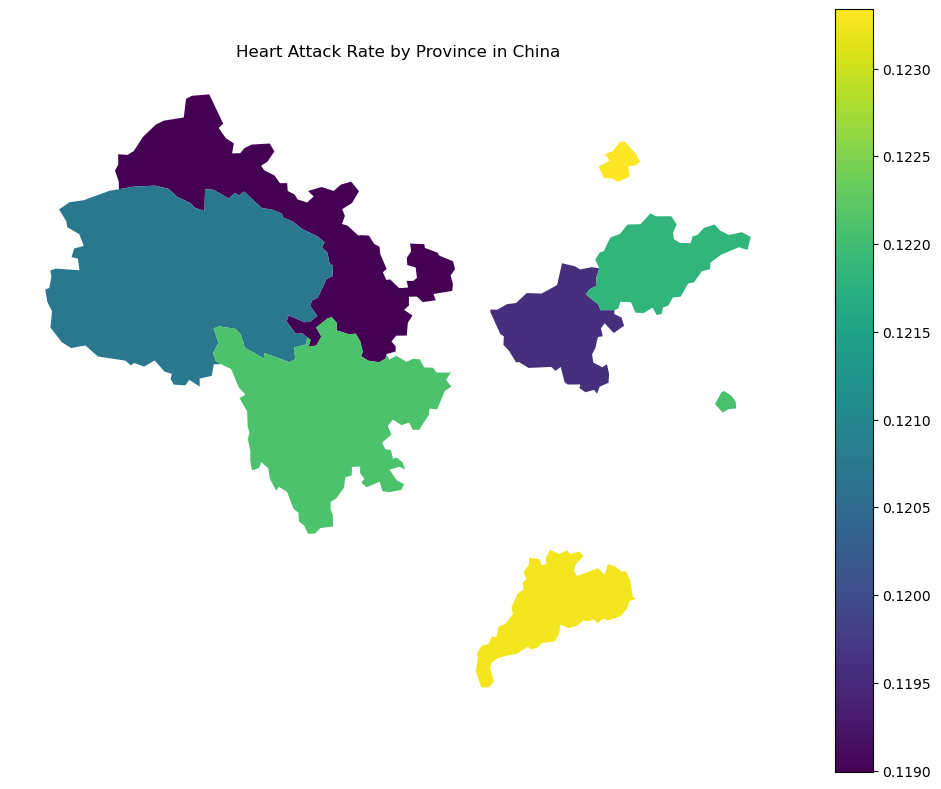

In [14]:
# Plotting the heart attack rate by province 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
gdf_map.plot(
    column="heart_attack_rate",
    legend=True,
    ax=ax
)

ax.set_title("Heart Attack Rate by Province in China")
ax.axis("off")
plt.tight_layout()
plt.show()


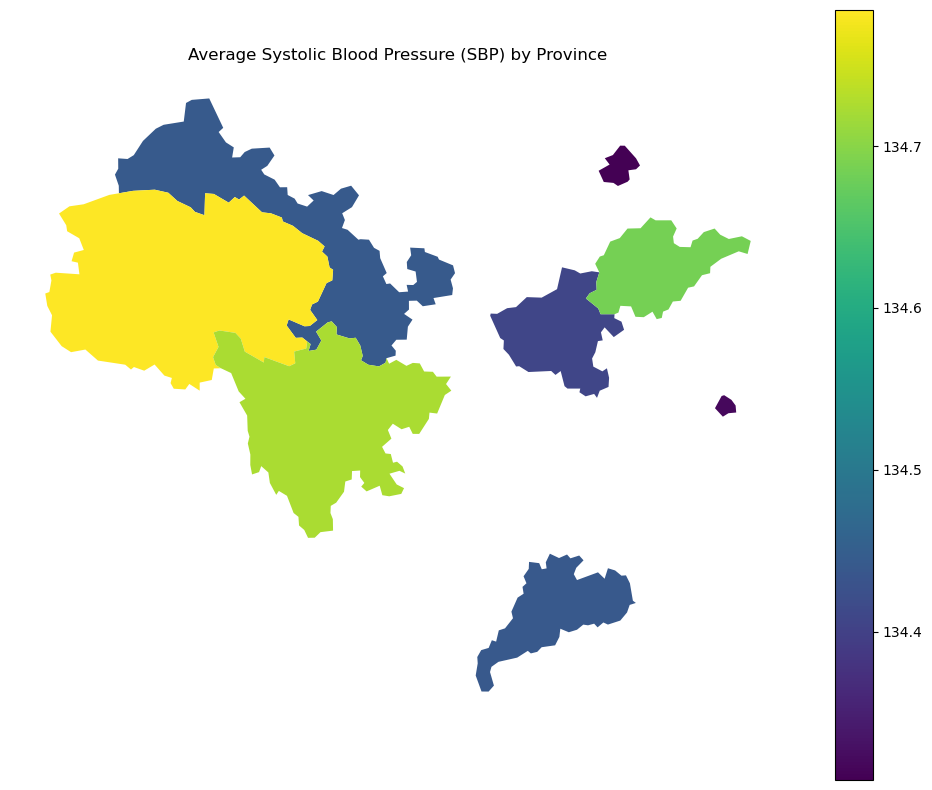

In [15]:
# SBP per province 
fig, ax = plt.subplots(figsize=(10, 8))
gdf_map.plot(
    column="mean_sbp",
    legend=True,
    ax=ax
)

ax.set_title("Average Systolic Blood Pressure (SBP) by Province")
ax.axis("off")
plt.tight_layout()
plt.show()


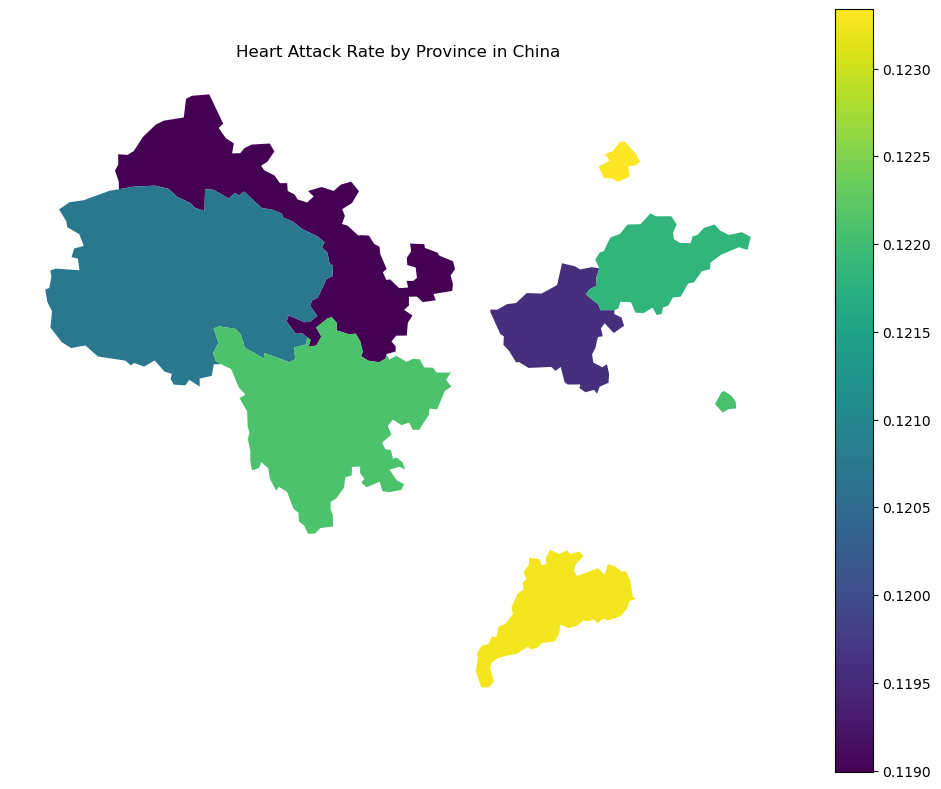

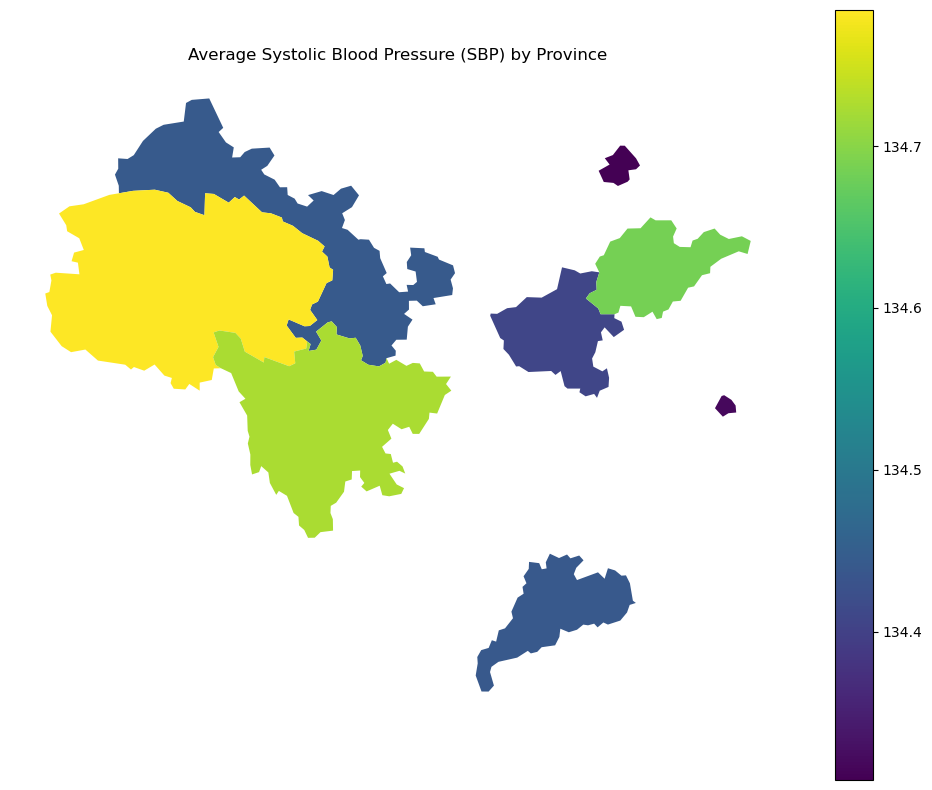

In [16]:
# Save the plots in our folder path

# Heart Attack Rate by Province
fig, ax = plt.subplots(figsize=(10, 8))
gdf_map.plot(
    column="heart_attack_rate",
    legend=True,
    ax=ax
)

ax.set_title("Heart Attack Rate by Province in China")
ax.axis("off")
plt.tight_layout()

# save to reports/figures
fig.savefig("../reports/figures/heart_attack_rate_by_province.png",
            dpi=300, bbox_inches="tight")

# Double check what is being saved
plt.show()


# Average SBP by Province
fig, ax = plt.subplots(figsize=(10, 8))
gdf_map.plot(
    column="mean_sbp",
    legend=True,
    ax=ax
)

ax.set_title("Average Systolic Blood Pressure (SBP) by Province")
ax.axis("off")
plt.tight_layout()

fig.savefig("../reports/figures/mean_sbp_by_province.png",
            dpi=300, bbox_inches="tight")

# Double check what is being saved
plt.show()


## Spatial Context Enhancement Using Basemap Tiles

To provide additional geographic context beyond province boundaries, we overlay our choropleth maps on top of a modern basemap (e.g., OpenStreetMap).

### Adding a basemap allows us to:

- Situate each province within recognizable geographic features.  
- Include familiar reference points such as coastlines and national borders.  
- Improve visual interpretability for audiences less familiar with the raw province shapes.  
- Visually align health outcomes with real-world spatial positions.  

Using the `contextily` library, we reproject our GeoDataFrame to a web-mercator coordinate system and layer the choropleth over a recent OpenStreetMap background.

This produces a richer and more intuitive view of how heart-attack-related metrics vary across China’s geography.


In [18]:
# Install this first
!pip install contextily


In [19]:
# import statements again
# the contextily is required
import contextily as cx


In [20]:
# Make sure gdf_map has a CRS; if not, set it first:
# gdf_map = gdf_map.set_crs(epsg=4326)

gdf_map_web = gdf_map.to_crs(epsg=3857)


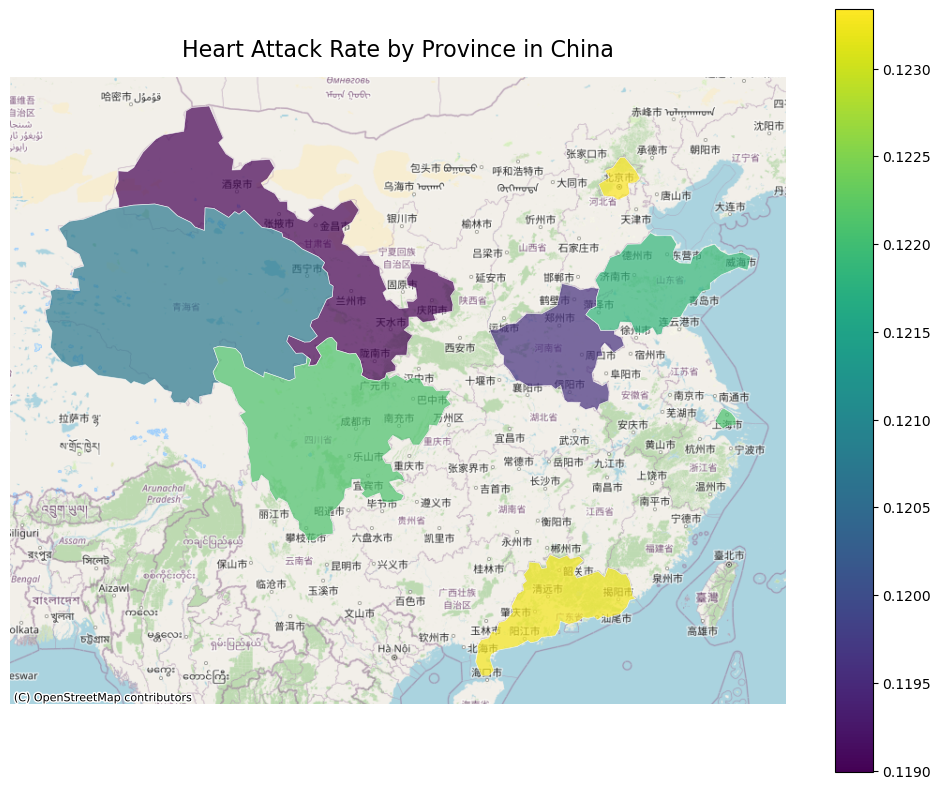

In [21]:
# Overlay the analysis with a map of the current provinces 
# in the region
fig, ax = plt.subplots(figsize=(10, 8))

# Choropleth on top
# The alpha level is the transparency value
gdf_map_web.plot(
    column="heart_attack_rate",
    legend=True,
    alpha=0.7,       
    edgecolor="white",
    linewidth=0.5,
    ax=ax
)

# Add basemap behind it
# and we can try different provinces in the mapnik if wanted
cx.add_basemap(
    ax,
    source=cx.providers.OpenStreetMap.Mapnik  
)

ax.set_title("Heart Attack Rate by Province in China", fontsize=16, pad=15)
ax.axis("off")
plt.tight_layout()
plt.show()


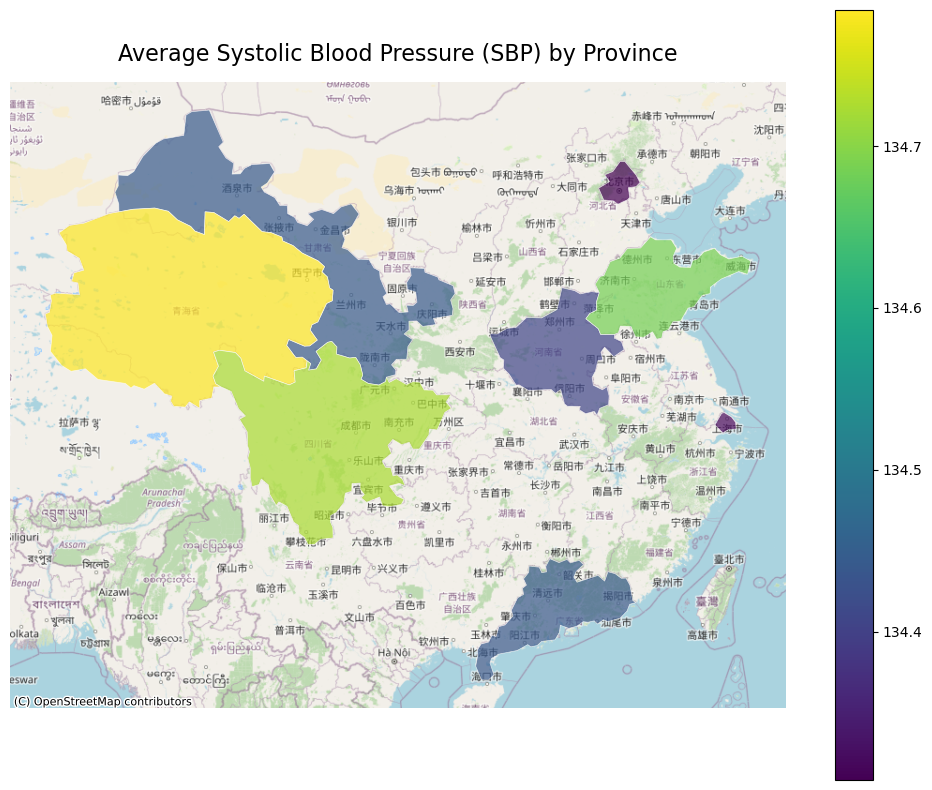

In [22]:
# Overlay the analysis with a map of the current provinces 
# in the region
fig, ax = plt.subplots(figsize=(10, 8))

# Choropleth on top
# The alpha level is the transparency value
gdf_map_web.plot(
    column="mean_sbp",
    legend=True,
    alpha=0.7,
    edgecolor="white",
    linewidth=0.5,
    ax=ax
)

# Add basemap behind it
# and we can try different provinces in the mapnik if wanted
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

ax.set_title("Average Systolic Blood Pressure (SBP) by Province", fontsize=16, pad=15)
ax.axis("off")
plt.tight_layout()
plt.show()


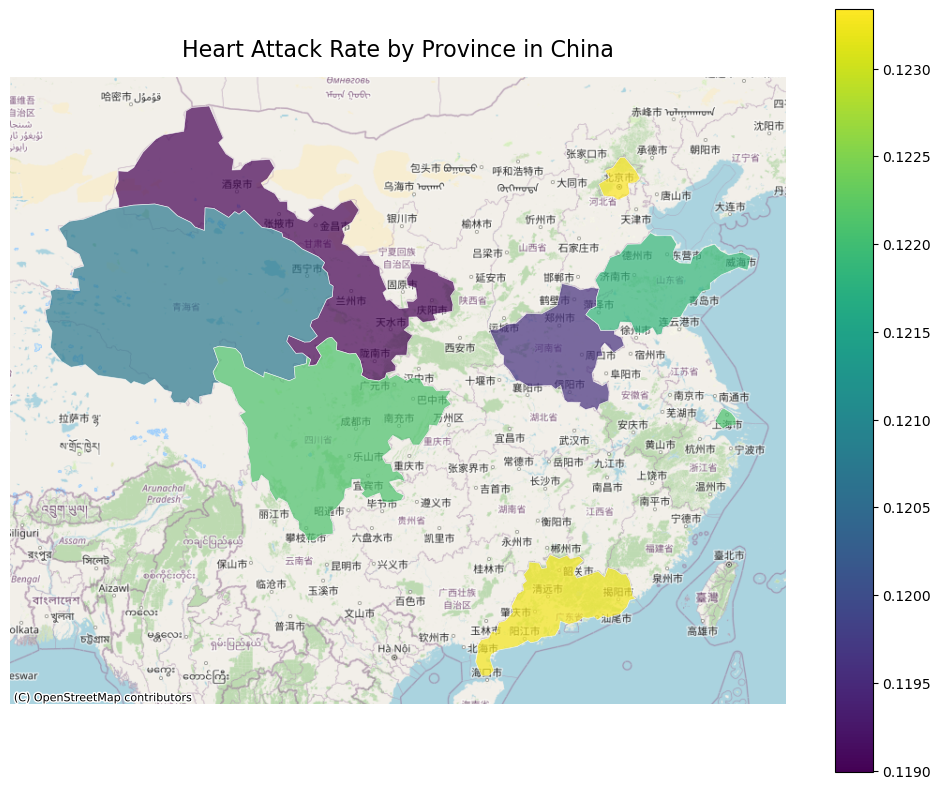

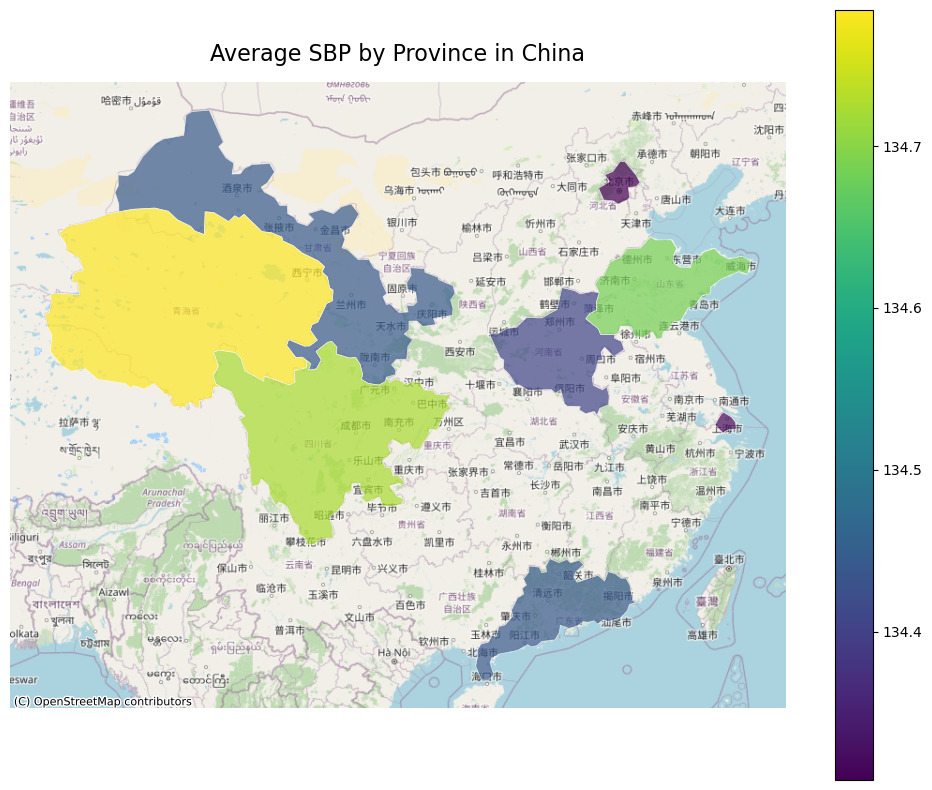

In [23]:
# Save the updated basemaps 
# Heart Attack Rate + basemap
fig, ax = plt.subplots(figsize=(10, 8))

gdf_map_web.plot(
    column="heart_attack_rate",
    legend=True,
    alpha=0.7,
    edgecolor="white",
    linewidth=0.5,
    ax=ax
)

cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

ax.set_title("Heart Attack Rate by Province in China", fontsize=16, pad=15)
ax.axis("off")
plt.tight_layout()

# save figure
fig.savefig("../reports/figures/heart_attack_rate_with_basemap.png",
            dpi=300, bbox_inches="tight")

# Check to see if what is saved
plt.show()


# Mean SBP + basemap
fig, ax = plt.subplots(figsize=(10, 8))

gdf_map_web.plot(
    column="mean_sbp",
    legend=True,
    alpha=0.7,
    edgecolor="white",
    linewidth=0.5,
    ax=ax
)

cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

ax.set_title("Average SBP by Province in China", fontsize=16, pad=15)
ax.axis("off")
plt.tight_layout()

fig.savefig("../reports/figures/mean_sbp_with_basemap.png",
            dpi=300, bbox_inches="tight")

# Check to see what is saved
plt.show()

## 2) Combining `heart_attack_china` with GIS Data

We create a dictionary of the first-level administrative regions (provinces and direct-administered municipalities) and associate each with:

- A **province-level centroid** to represent rural locations.  
- A **largest city / city seat** to represent urban locations.

To construct this dictionary, we:

1. Retrieve a list of the largest city in each administrative region.  
2. Obtain GIS data describing the province and city boundaries.  
3. Determine the **geodesic center** of each element.  
4. Save the results as a GeoJSON file for reuse.

Direct-administered municipalities (e.g., Beijing, Shanghai) are treated as provinces for the purposes of this data.


In [39]:
from bs4 import BeautifulSoup
from pprint import pprint

def get_parsed_page(title: str) -> list:
    """Imported from Assignment 3 - Function retrieves and parses a Wikipedia page given a title"""
    # Create the User-Agent tag to comply with Wikipedia's TOS
    headers = { "User-Agent": "Drexel_Disc_511/1.0 (srs359@drexel.edu)" }

    # Make the Request
    response = requests.get("https://en.wikipedia.org/api/rest_v1/page/html/" + title, headers=headers)
    
    if response.status_code != 200:
        print(f"Status Code: {response.status_code}")
        return None
    
    original_response: str = response.text

    # Parse the result
    parsed_response = BeautifulSoup(original_response, "html.parser")
    
    return [original_response, parsed_response]

def parse_wiki_table(table, primary_key: str, secondary_key: str, print_trace: bool = False) -> dict:
    """parses the given table into dictionary"""
    r_value: dict = {}

    # Get the Header and store for use
    header_list = []
    # print(table)

    header_row = table.find("tr")
    for tag in header_row.find_all("th"):
        header_list.append(tag.get_text())

    if print_trace:
        print(f"Header: {header_list}")

    # If the given primary key isn't in the table, use the first column as the primary
    primary_key_idx = 0
    if primary_key in header_list:
        primary_key_idx = header_list.index(primary_key)

    if secondary_key not in header_list:
        return
    
    secondary_key_idx = header_list.index(secondary_key)
    if print_trace:
        print(f"Indices: {primary_key_idx} | {secondary_key_idx}")

    # Get the Rows
    for row in table.find_all("tr")[1:]:
        row_values = row.find_all(["th","td"])
        row_length = len(row_values)

        if print_trace:
            print(row)
            print(f"Row length of {len(row_values)}")
        if row_length < min(primary_key_idx, secondary_key_idx):
            if print_trace:
                print("Row too short")
                print(row)
            break

        # Retrieve the values
        row_key = row_values[primary_key_idx].get_text()
        if len(header_list) > len(row_values):
            if print_trace:
                print(f"Offsetting Secondary Key: {len(header_list)} | {len(row_values)}")
            value_key = row_values[secondary_key_idx-1].get_text()
        else:
            value_key = row_values[secondary_key_idx].get_text()

        # Add this row to the return dictionary
        if print_trace:
            print(f"Row: {row_key} | {value_key}")
        r_value[row_key] = value_key

    return r_value

province_page_title = "Provinces of China"

province_page = get_parsed_page(province_page_title)

province_dict: dict = {}

if province_page is not None:
    # Find the province table
    for table in province_page[1].body.find_all('table'):
        # "wikitable sortable jquery-tablesorter"
        if "wikitable" in table.get("class"):
            # print(f"Class: {table.get("class")}")
            province_dict = parse_wiki_table(table, "Province", "Largest city")
            print(province_dict)
            # We found the table, now exit
            break

{'Hebei': 'Shijiazhuang', 'Shanxi': 'Taiyuan', 'Liaoning': 'Shenyang', 'Jilin': 'Changchun', 'Heilongjiang': 'Harbin', 'Jiangsu': 'Suzhou', 'Zhejiang': 'Hangzhou', 'Anhui': 'Hefei', 'Fujian[b]': 'Quanzhou', 'Jiangxi': 'Ganzhou', 'Shandong': 'Linyi', 'Henan': 'Zhengzhou', 'Hubei': 'Wuhan', 'Hunan': 'Changsha', 'Guangdong[c]': 'Guangzhou', 'Hainan[d]': 'Haikou', 'Sichuan': 'Chengdu', 'Guizhou': 'Zunyi', 'Yunnan': 'Kunming', 'Shaanxi': "Xi'an", 'Gansu': 'Lanzhou', 'Qinghai': 'Xining', 'Taiwan[f]': 'New Taipei City'}


### Obtaining the City Seat in Each Independent Municipality

Despite what one might think at first glance, there are **rural areas** even within direct-administered municipalities like Beijing and Shanghai. To avoid strange combinations (for example, a patient being labeled as living in “Beijing” but also marked as “Rural”), we:

- Use the **city seat** (main administrative city) as the representative **urban** location.  
- Associate **rural** patients with the **province-level centroid** instead of the city seat.

This ensures that our “urban vs. rural” reference points remain consistent with how the locations are labeled in the dataset.



In [25]:
autonomous_page_title = "Autonomous regions of China"

autonomous_page = get_parsed_page(autonomous_page_title)

autonomous_dict: dict = {}

if autonomous_page is not None:
    # Find the autonomous table
    for table in autonomous_page[1].body.find_all('table'):
        # "wikitable sortable jquery-tablesorter"
        if "wikitable" in table.get("class"):
            # print(f"Class: {table.get("class")}")
            autonomous_dict = parse_wiki_table(table, "Name in English", "Capital")
            # Clean up the entry
            for key, value in autonomous_dict.items():
                position = value.find("(")
                autonomous_dict[key] = value[:position]

            pprint(autonomous_dict)
            # We found the table, now exit
            break

{'Guangxi Zhuang Autonomous Region': 'Nanning',
 'Inner Mongolia Autonomous Region': 'Hohhot',
 'Ningxia Hui Autonomous Region': 'Yinchuan',
 'Tibet Autonomous Region': 'Lhasa',
 'Xinjiang Uygur Autonomous Region': 'Ürümqi'}


### Determining the Geodesic Center of Each Element

We compute a **geodesic center (centroid)** for each province using its polygon geometry. This centroid:

- Serves as a **single representative point** for the province.  
- Allows us to plot simplified **point-based maps** (urban and rural reference points).  
- Provides a consistent anchor for linking province-level data to coordinates.

These centroids are geometric approximations and are used strictly for **visual and analytical reference**, not to indicate specific patient locations.


In [38]:
municipality_page_title = "Direct-administered municipality"

municipality_page = get_parsed_page(municipality_page_title)

municipality_dict: dict = {}

if municipality_page is not None:
    # Find the municipality table
    for table in municipality_page[1].body.find_all('table'):
        if "wikitable" in table.get("class"):
            # print(f"Class: {table.get("class")}")
            municipality_dict = parse_wiki_table(table, "Division name", "City seat")

            pprint(municipality_dict)
            # We found the table, now exit
            break

{'Beijing': 'Tongzhou',
 'Chongqing': 'Yuzhong',
 'Shanghai': 'Huangpu',
 'Tianjin': 'Hexi'}


### Determine the geodesic center of each element

In [40]:
!pip install osmnx
!pip install overpy
import overpy
import osmnx as ox

osm_api = overpy.Overpass()
ox.settings.timeout = 60
ox.settings.use_cache = True

def get_centroid(place_name) -> tuple:
    geodataframe = ox.geocode_to_gdf(place_name)#, tags={"admin_level": "4"})
    
    if geodataframe is None:
        print(f"Unable to find {place_name}")
        return None
    else:
        centroid = geodataframe.to_crs('epsg:4087').centroid.to_crs(geodataframe.crs)
        # print(f"Geodesic Center (Centroid) of {place_name}:\\n{centroid}")
        # coordinates_tuple = tuple(centroid[0].coords)[0]
        return tuple(centroid[0].coords)[0]

def process_first_level_division(division_dict: dict, print_trace: bool = False) -> dict:
    """Processes a first level division dictionary and find the geodesic
       center of the division and the sub-area"""
    r_value: dict = {}

    for division, capital in division_dict.items():
        try:
            # Get Rural value
            place_name = division + ", China"
            longitude, latitude = get_centroid(place_name)

            if print_trace:
                print(f"Geodesic Center (Centroid) of {place_name}: {latitude}, {longitude}")

            # r_value[division]["Rural"] = (latitude, longitude)
            rural = (latitude, longitude)

            # Get Urban value
            place_name = capital + ", China"
            longitude, latitude = get_centroid(place_name)
            if print_trace:
                print(f"Geodesic Center (Centroid) of {place_name}: {latitude}, {longitude}")

            # r_value[division]["Urban"] = (latitude, longitude) 
            urban = (latitude, longitude)
            
            if rural is not None and urban is not None:
                r_value[division] = { "Rural": rural, "Urban": urban }

        except ValueError as exc:
            print(f"ERROR: {exc}")
            continue
        
        except TypeError as exc:
            print(f"ERROR: {exc}")
            continue

    return r_value

province_centers = process_first_level_division(province_dict)
# pprint(f"Province Centers: {province_centers}")

autonomous_centers = process_first_level_division(autonomous_dict)
# pprint(f"Autonomous Centers: {autonomous_centers}")

municipality_centers = process_first_level_division(municipality_dict)
# pprint(f"Municipality Centers: {municipality_centers}")

national_centroid_dict = province_centers | autonomous_centers | municipality_centers

pprint(national_centroid_dict)


ERROR: Nominatim did not geocode query 'Inner Mongolia Autonomous Region, China' to a geometry of type (Multi)Polygon.
{'Anhui': {'Rural': (31.82612180594919, 117.22585516559734),
           'Urban': (31.763470291977853, 117.35653738260042)},
 'Beijing': {'Rural': (40.17934377083946, 116.42072511464755),
             'Urban': (39.8028172130268, 116.73040605411093)},
 'Chongqing': {'Rural': (30.056887456977677, 107.87434458537238),
               'Urban': (29.552496348625272, 106.53732119431666)},
 'Fujian[b]': {'Rural': (26.921050184196794, 118.97877719471613),
               'Urban': (25.01456843633409, 118.43176992375948)},
 'Gansu': {'Rural': (37.885271404892414, 100.60167573925908),
           'Urban': (36.3549318961551, 103.63818297759768)},
 'Guangdong[c]': {'Rural': (22.583070598187074, 113.94535923595662),
                  'Urban': (23.335906551811707, 113.53831432088654)},
 'Guangxi Zhuang Autonomous Region': {'Rural': (23.727035595804804,
                                    

### Save off results as a GeoJSON

Finally, we save the combined province geometries and attributes as a **GeoJSON** file under `../data/processed/` so that the same spatial layer can be reused in other notebooks or tools.


In [29]:
!pip install geojson
import geojson
from geojson import Feature, FeatureCollection, Point, dump
import os

def create_feature(key: str, value: dict, rural_or_urban: str) -> Feature:
    centroid_pnt = Point(value[rural_or_urban])
    properties = {
        "Province": key,
        "Rural_or_Urban": rural_or_urban
    }

    return Feature(geometry=centroid_pnt, properties=properties)

feature_list: list = []

for key, value in national_centroid_dict.items():
    # Create a feature from the Urban entry    
    feature_list.append(create_feature(key, value, "Rural"))

    # Create a feature from the Rural entry
    feature_list.append(create_feature(key, value, "Urban"))

collection = FeatureCollection(feature_list)

file_location = "../data/processed/urban_or_rural_centroids.geojson"

with open(file_location, 'w') as f:
    dump(collection, f)

print(f"GeoJson successfully written to {os.path.abspath(file_location)}")
pprint(collection)

GeoJson successfully written to C:\Users\rphelps\OneDrive - Drexel University\DSCI 511-900\Colab Notebooks\DSCI-511-Project\data\processed\urban_or_rural_centroids.geojson
{"features": [{"geometry": {"coordinates": [39.533892, 116.230883], "type": "Point"}, "properties": {"Province": "Hebei", "Rural_or_Urban": "Rural"}, "type": "Feature"}, {"geometry": {"coordinates": [38.130477, 114.439754], "type": "Point"}, "properties": {"Province": "Hebei", "Rural_or_Urban": "Urban"}, "type": "Feature"}, {"geometry": {"coordinates": [37.571595, 112.289301], "type": "Point"}, "properties": {"Province": "Shanxi", "Rural_or_Urban": "Rural"}, "type": "Feature"}, {"geometry": {"coordinates": [37.959172, 112.315685], "type": "Point"}, "properties": {"Province": "Shanxi", "Rural_or_Urban": "Urban"}, "type": "Feature"}, {"geometry": {"coordinates": [40.989143, 122.488067], "type": "Point"}, "properties": {"Province": "Liaoning", "Rural_or_Urban": "Rural"}, "type": "Feature"}, {"geometry": {"coordinates": 

In [30]:
from pathlib import Path

# Load your analysis-ready Heart Attack dataset
analysis_path = Path("../data/processed/heart_attack_china_analysis_ready.csv")
df_analysis = pd.read_csv(analysis_path)

# Load the centroid GeoJSON urban or rural centroids
centroids_path = Path("../data/processed/urban_or_rural_centroids.geojson")
gdf_centroids = gpd.read_file(centroids_path)

gdf_centroids.head()


,Province,Rural_or_Urban,geometry
0,Hebei,Rural,POINT (39.53389 116.23088)
1,Hebei,Urban,POINT (38.13048 114.43975)
2,Shanxi,Rural,POINT (37.5716 112.2893)
3,Shanxi,Urban,POINT (37.95917 112.31568)
4,Liaoning,Rural,POINT (40.98914 122.48807)


In [31]:
# Clean province names in centroids remove [b], [note], etc.
gdf_centroids["province_clean"] = (
    gdf_centroids["Province"]
    .str.replace(r"\[.*\]", "", regex=True)  
    .str.strip()
)

# Normalize Rural/Urban labels
gdf_centroids["urban_rural_clean"] = gdf_centroids["Rural_or_Urban"].str.strip()


In [32]:
# Set the columns for Province and Rural or Urban
PROV_COL = "Province"       
UR_COL   = "Rural_or_Urban"    

# Clean and make urban Urban and rural Rural
df_analysis["province_clean"] = df_analysis[PROV_COL].str.strip()
df_analysis["urban_rural_clean"] = (
    df_analysis[UR_COL]
    .str.strip()
    .str.capitalize()  
)

# Check the columns
df_analysis.columns



Index(['Patient_ID', 'Age', 'Gender', 'Smoking_Status', 'Hypertension',
       'Diabetes', 'Obesity', 'Cholesterol_Level', 'Air_Pollution_Exposure',
       'Physical_Activity', 'Diet_Score', 'Stress_Level',
       'Alcohol_Consumption', 'Family_History_CVD', 'Healthcare_Access',
       'Rural_or_Urban', 'Region', 'Province', 'Hospital_Availability',
       'TCM_Use', 'Employment_Status', 'Education_Level', 'Income_Level',
       'SBP', 'Chronic_Kidney_Disease', 'Previous_Heart_Attack',
       'CVD_Risk_Score', 'Heart_Attack', 'Gender_simple', 'SBP_missing',
       'SBP_hypertensive', 'WHO_Mean_Blood_Pressure_SEX_BTSX_latest',
       'WHO_Mean_Blood_Pressure_SEX_MLE_latest',
       'WHO_Mean_Blood_Pressure_SEX_FMLE_latest', 'province_clean',
       'urban_rural_clean'],
      dtype='object')

In [33]:
# Merge the health risk features plus the proince and urban rural clean versions
# and left joing to keep all rows form the heart attack datset
df_merged = df_analysis.merge(
    gdf_centroids[["province_clean", "urban_rural_clean", "geometry"]],
    on=["province_clean", "urban_rural_clean"],
    how="left"   
)

# Turn into a GeoDataFrame
gdf_merged = gpd.GeoDataFrame(df_merged, geometry="geometry", crs="EPSG:4326")

gdf_merged.head()


,Patient_ID,Age,Gender,Smoking_Status,Hypertension,Diabetes,Obesity,Cholesterol_Level,Air_Pollution_Exposure,Physical_Activity,...,Heart_Attack,Gender_simple,SBP_missing,SBP_hypertensive,WHO_Mean_Blood_Pressure_SEX_BTSX_latest,WHO_Mean_Blood_Pressure_SEX_MLE_latest,WHO_Mean_Blood_Pressure_SEX_FMLE_latest,province_clean,urban_rural_clean,geometry
0,1,55,Male,Non-Smoker,0,0,1,Normal,High,High,...,0,M,False,0,23.013535,26.032547,NaN,Beijing,Rural,POINT (40.17934 116.42072)
1,2,66,Female,Smoker,1,0,0,Low,Medium,High,...,0,F,False,1,23.013535,NaN,19.842985,Qinghai,Urban,POINT (36.82856 101.43736)
2,3,69,Female,Smoker,0,0,0,Low,Medium,High,...,0,F,False,1,23.013535,NaN,19.842985,Henan,Rural,POINT (33.88184 113.61431)
3,4,45,Female,Smoker,0,1,0,Normal,Medium,Low,...,0,F,False,1,23.013535,NaN,19.842985,Qinghai,Rural,POINT (35.84817 96.43002)
4,5,39,Female,Smoker,0,0,0,Normal,Medium,Medium,...,0,F,False,1,23.013535,NaN,19.842985,Guangdong,Urban,POINT (23.33591 113.53831)


In [34]:
# Save the merged dataset 
out_path = Path("../data/processed/heart_attack_china_with_centroids.geojson")
gdf_merged.to_file(out_path, driver="GeoJSON")
print(f"Saved merged centroid dataset to: {out_path.resolve()}")


Saved merged centroid dataset to: C:\Users\rphelps\OneDrive - Drexel University\DSCI 511-900\Colab Notebooks\DSCI-511-Project\data\processed\heart_attack_china_with_centroids.geojson


In [35]:
# Check the merged dataset's geometry
gdf_merged.geometry.isna().value_counts()


geometry
False    239266
Name: count, dtype: int64

In [92]:
# Check the merged dataset's bounds
gdf_merged.total_bounds


array([ 22.583071,  96.430021,  40.179344, 121.873986])

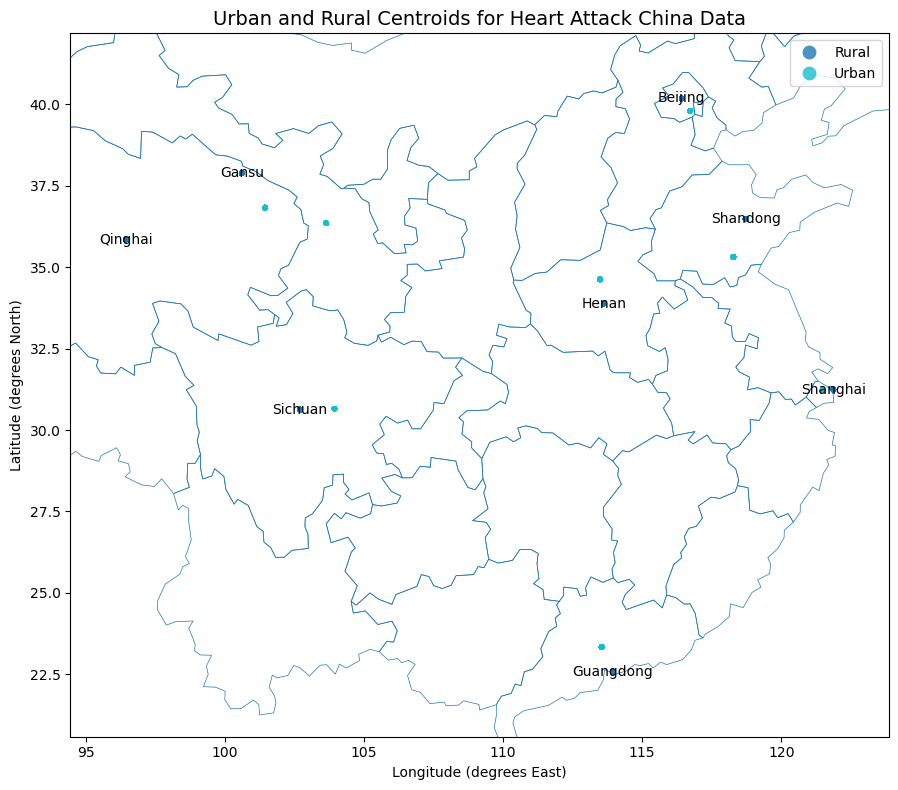

Figure saved to: ../reports/figures/urban_rural_centroids_with_labels.png


In [100]:
# Load China provinces polygons comes from Kaggle download. 
geojson_path = "../data/external/gadm36_CHN_1.json"  # adjust path if needed
gdf_prov = gpd.read_file(geojson_path)
gdf_prov = gdf_prov.to_crs(epsg=4326)  # match CRS of your centroids

# Keep only rows with a valid centroid geometry
gdf_plot = gdf_merged[~gdf_merged.geometry.isna()].copy()

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Plot China province outlines as a light background
gdf_prov.boundary.plot(ax=ax, linewidth=0.5)

# Plot centroids, colored by Urban vs Rural
gdf_plot.plot(
    ax=ax,
    column="urban_rural_clean",   # 'urban' / 'rural'
    categorical=True,
    legend=True,
    markersize=8,
    alpha=0.8
)

# Add province labels
# Take one point per province (to avoid double labels from urban/rural)
# Just keep the first row per province_clean
label_points = (
    gdf_plot
    .sort_values("urban_rural_clean")           # so 'rural' might come first
    .drop_duplicates(subset="province_clean")   # one label per province
)

for _, row in label_points.iterrows():
    x = row.geometry.x
    y = row.geometry.y
    name = row["province_clean"]

    ax.text(
        x, y,
        name,
        fontsize=10,
        ha="center",
        va="center"
    )

# Titles and axis labels
ax.set_title("Urban and Rural Centroids for Heart Attack China Data", fontsize=14)
ax.set_xlabel("Longitude (degrees East)")
ax.set_ylabel("Latitude (degrees North)")

# Optional: zoom the map nicely around your data
minx, miny, maxx, maxy = gdf_plot.total_bounds
pad_x, pad_y = 2, 2  # degrees of padding
ax.set_xlim(minx - pad_x, maxx + pad_x)
ax.set_ylim(miny - pad_y, maxy + pad_y)

plt.tight_layout()


# Export the figure
fig_dir = Path("../reports/figures")
fig_dir.mkdir(parents=True, exist_ok=True)
fig_path = fig_dir / "urban_rural_centroids_with_labels.png"
fig.savefig(fig_path, dpi=300, bbox_inches="tight")

plt.show()

print(f"Figure saved to: {fig_path}")


# Project References & Data Sources

This project integrates medical data, geographic reference data, and programmatically generated spatial data to support analysis and visualization.

---

## 1. Heart Attack Dataset

- **Source:** Course-provided `heart_attack_china.csv`  
- **Content:** Patient-level records with demographic fields (age, sex), clinical measurements (e.g., SBP), and province information.  
- **Usage:** Basis for all **individual-level** analysis and province-level aggregation.

---

## 2. WHO Health Indicators for China

- **Source:** Course-provided `who_health_china.csv`  
- **Content:** Province-level health indicators (e.g., risk factors, system metrics) by sex and year.  
- **Usage:** After cleaning and filtering to the **latest year per indicator × sex**, this dataset is merged to provide **contextual health information**.

---

## 3. Air Quality and Geographic Reference

- **OpenAQ API:** Used to retrieve **PM2.5 measurements** for selected urban locations.  
- **OpenStreetMap / Nominatim:** Used for **forward geocoding** of city names to coordinates and for general geographic reference.  
- **GADM GeoJSON:** Province-level boundary file used to create **spatial visualizations**.

---

## 4. Software and Libraries

Key Python libraries include:

- `pandas`, `numpy` – data manipulation and numerical operations  
- `geopandas`, `shapely` – spatial data handling and geometry operations  
- `matplotlib` / `contextily` – mapping and visualization  
- `requests` – API calls to OpenAQ and Nominatim  

All datasets and generated outputs used in this notebook are included within the repository (or clearly documented) to ensure **reproducibility for grading and future work**.

This project is for **academic purposes only**, to demonstrate data acquisition, cleaning, integration, and spatial visualization in a university setting.


# Interpretation of the Map

This visualization shows the **geographic reference structure** of the dataset.

For each province, we include two representative points:

- An **urban location** (capital city seat / centroid)  
- A **rural location** (province-level centroid)

These points do **not** represent individual heart attack events, severity, risk, or frequency.

They exist to:

- Validate that our province-level joins and geometries are **aligned correctly**  
- Provide **spatial reference context** for the heart attack and WHO data  
- Support potential **future geo-analysis** and spatial grouping  
- Confirm the **real-world plausibility** of our provincial mappings

No health outcomes are encoded in the **color, size, or exact location** of these reference points.  
This map illustrates **geography only**, not medical outcomes.

